In [1]:
from torchvision import models, transforms
from torchsummary import summary
import torch
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

In [2]:
model = models.resnet50(pretrained=True)

/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
def get_image(path, transform):
    '''
    get image from path and transform it tensor
    '''
    img = PIL.Image.open(path)
    img_t = transform(img)
    img_t = img_t.unsqueeze(0)
    img_it = transform(img)
    return img_t
img = get_image('images/nosacz.jpg', transform)
type(img), img.shape

(torch.Tensor, torch.Size([1, 3, 224, 224]))

In [5]:
last_conv_layer = model.layer4[-1].conv3

In [6]:
shape = None
activations = []

def hook_get_shape_of_last_conv_layer(module, inp, out):
    global shape
    shape = out.shape
    activations.append(out)

hook = last_conv_layer.register_forward_hook(hook_get_shape_of_last_conv_layer)

In [7]:
pred = model(img)
hook.remove()
c = pred.argmax().item()
y_c = pred[0, c]
y_c

tensor(1.9320, grad_fn=<SelectBackward0>)

In [8]:
ablation = np.zeros(shape[2:])

activations = activations[0]
weigths = np.zeros(shape[:2])
weigths.shape

(1, 2048)

In [9]:
for i in range(shape[1]):
    def hook_zeros_k_map(module, inp, out):
        modified_output = out.clone()
        modified_output[:, i] = 0
        return modified_output

    hook = last_conv_layer.register_forward_hook(hook_zeros_k_map)
    pred = model(img)
    c = pred.argmax().item()
    y_k = pred[0, c].item()
    w = (y_c - y_k).item() / y_c.item()
    print(w)
    weigths[0, i] = w

    hook.remove()


-0.0046709593776529555
0.0016618577847338242
-0.0031081318797126925
-8.175397507879695e-05
-0.0010968606905477534
-0.001862386402851628
-0.0026772730057691156
0.004126817259751136
-0.004259351251048688
-0.003843424046515729
0.00018991602663587698
-2.406343417413646e-06
-0.001862571506191429
-0.003586377208645338
0.0008610390356412162
0.035983533947304656
0.0007577513720322304
-0.0019869609505377343
-0.002215316770738963
-0.0009969048870551867
0.002323725626749111
0.004250713095191305
0.005997656715120345
-0.0016540217433489131
0.0017873578491189358
0.007360881111641809
-0.0009956708647898462
2.2520906342461048e-05
-0.0009169402442611332
0.003643882646210197
0.0002473597630874694
0.003978179277890893
0.00084524355064486
0.0012574069872685306
0.004674291237769374
0.001955369980545022
-0.00337745723912322
-0.0010186853800384435
-0.0005515462514938611
0.007122468009978057
-0.003337783423292528
-0.003139784550818672
-0.0012836916615202797
0.003461247350939828
0.0003855702568055865
-0.002497

In [10]:
type(weigths), weigths.shape

(numpy.ndarray, (1, 2048))

In [11]:
type(activations)

torch.Tensor

In [12]:
activations = activations.detach().numpy()

In [25]:
for i, w in enumerate(weigths[0]):
    ablation += w * activations[0, i, :, :] * 10

ablation = np.maximum(ablation, 0)

heatmap = cv2.resize(ablation, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

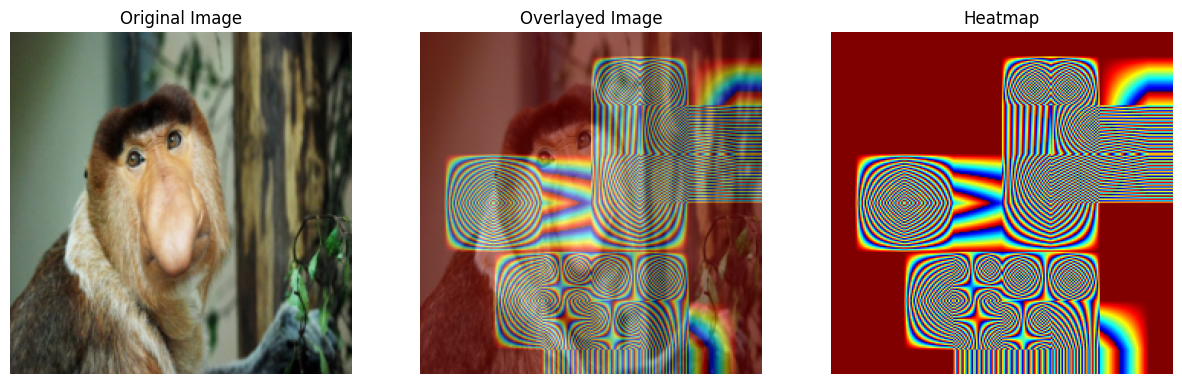

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img[0].detach().numpy().transpose(1, 2, 0))
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[2].imshow(heatmap)
axs[2].set_title('Heatmap')
axs[2].axis('off')

overlayed_img = heatmap * 0.5 + img.detach().numpy().transpose(0, 2, 3, 1)[0] * 0.5
overlayed_img = overlayed_img / overlayed_img.max()

axs[1].imshow(overlayed_img)
axs[1].set_title('Overlayed Image')
axs[1].axis('off')

plt.show()